# MSCA 31008 Final Project
### Author:  Yifan Gao
### Date:  June 3, 2021

This notebook takes ~2 hours to finish.

## 1. Data preprocessing & clean-up

### 1a. Load tokenizers for LSTM and FinBERT models

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Install all packages
# Note: to make tensorflow loaded, please downgrade/update to python 3.7
# Suggest downloading conda: https://repo.anaconda.com/archive/ with version 2019.10
import numpy as np
import pandas as pd 
from tqdm.notebook import tqdm
import tensorflow as tf
import datetime as dt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import holidays
import pickle
import torch
import torch.nn.functional as F
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Set up parameters for LSTM model
max_features = 20000
maxlen = 100
# loading tokenizer for LSTM model, which serves as a dictionary of words
with open('Data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# loading tokenizer for FINBERT model
tokenizer1 = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [2]:
# Load LSTM model from local
LSTM_model = tf.keras.models.load_model('Data/Model1-LSTM.h5', compile = False)

In [3]:
# Load FINBERT model from FINBERT Github
BERT_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

### 1b. Data preprocessing

In [4]:
# Initial data preprocessing for two datasets with headline data
data1 = pd.read_csv('Data/analyst_ratings_processed.csv', index_col=0)
data1.dropna(inplace = True)
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data2 = pd.read_csv('Data/us_equities_news_dataset.csv', index_col=0)
data2.dropna(inplace = True)
data2.reset_index(drop=True, inplace=True)
data2.rename(columns={'release_date':'date'}, inplace=True)
data2.drop(inplace=True, columns=['category', 'content', 'provider', 'url', 'article_id'], axis=1)

In [5]:
# Combine two datasets
rawdata = pd.concat([data1, data2])
# Drop duplicates
rawdata.drop_duplicates(keep='first', inplace=True)

### 1c. Missing data by column

In [6]:
# Calculate missing data % by column
def missing_perc(df):
    missing_df = pd.DataFrame()
    missing_df['Col Name'] = list(df.columns)
    missing_df['Missing %'] = [round(i/df.shape[0] * 100,2) for i in df.isnull().sum()]
    missing_df.sort_values(by=['Missing %'], ascending=False,inplace=True)
    missing_df['Missing %'] = missing_df['Missing %'].astype('str') + '%'
    pd.set_option('display.max_rows', None)
    return missing_df
missing_perc(rawdata)

,Col Name,Missing %
0,title,0.0%
1,date,0.0%
2,ticker,0.0%


No missing data!

## 2. Processing headline text with NLP

### 2a. Create headline dictionary

In [7]:
# A list of tickers selected based on our research
# We will use the sentiment scores of these tickers for the Fama French model
tickerSymbols = ["AAPL","IBM","NFLX","AMZN","MU","BAC","AMC","GE","MSFT","GOOG","GME","TSLA"]

In [8]:
# Create headline dictionary for tickers listed above with date as key and headlines as value
hl_dict = {}
# variable for tqdm progress bar use
# total = rawdata['date'].nunique()
for ticker in tickerSymbols:
    hl_dict[ticker] = {}
    for i in tqdm(rawdata[rawdata['ticker']==ticker]['date'].unique()):
        hl_dict[ticker][i] = rawdata.loc[(rawdata['ticker'] == ticker) & (rawdata['date'] == i)]['title'].tolist()

  0%|          | 0/2353 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/1541 [00:00<?, ?it/s]

  0%|          | 0/2547 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1119 [00:00<?, ?it/s]

  0%|          | 0/1760 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

### 2a. Define LSTM and FinBERT models

In [9]:
# Sentiment converter from LSTM model
def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    for sentence in sentenceList:
        # Convert each head line into a vector, 
        # with each integer being the index of a token in a dictionary
        token = tokenizer.texts_to_sequences([sentence])
        # This function transforms a list of lists of integers
        # into a 2D Numpy array of shape (num_samples, num_timesteps). 
        # num_timesteps is either the maxlen argument if provided, 
        # or the length of the longest sequence in the list.
        X = pad_sequences(token, maxlen=maxlen)
        # Run pre-defined LSTM model to calculate sentiment scores
        # The sentiment scores have three categories: negative, neutral
        # and positive with scale of 0 to 100.
        sentiment_dict = LSTM_model.predict(X).tolist()[0]
        negAvg += sentiment_dict[0]
        neuAvg += sentiment_dict[1]
        posAvg += sentiment_dict[2]
    posAvg=(posAvg/len(sentenceList))*100
    negAvg=(negAvg/len(sentenceList))*100
    neuAvg=(neuAvg/len(sentenceList))*100
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [10]:
# Function to convert headline list into sentiment scores
def SentimentAnalyzer(doc):
    # Convert head line list into multiple BatchEncoding objects
    pt_batch = tokenizer1(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
    # The pre trained BERT_model transforms multiple BatchEncoding objects
    # into a sequence classifier output, with each row represents headline and three columns representing
    # positive, neatral and negative sentiment scores
    outputs = BERT_model(**pt_batch)
    # Applies softmax function on sequence classifier output
    # and convert the results to a tensor object matrix
    # Softmax function is defined as exp(Xi)/SigmaSum(Xj)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    # Return numpy matrix with each row represents headline and three columns representing
    # positive, neatral and negative sentiment scores
    return pt_predictions.detach().cpu().numpy()

In [11]:
# Sentiment converter from FINBERT model
def findPercentageBySentences1(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    # Convert headline list into sentiment scores
    sentimentArr = SentimentAnalyzer(sentenceList)
    # Take average of headlines for positive, neutral and negative scores
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]*100
    negAvg=sentimentArr[1]*100
    neuAvg=sentimentArr[2]*100
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

### 2c. Create sentiment score dictionary

In [12]:
# Append # of articles and sentiment scores of each date to a dictionary
# This is for LSTM model
ss_dict = {}
# This is for FINBERT model
ss_dict1 = {}
for ticker in hl_dict:
    ss_dict[ticker] = {}
    ss_dict1[ticker] = {}
    for i in tqdm(hl_dict[ticker]):
            ss_dict[ticker][i] = findPercentageBySentences(hl_dict[ticker][i])
            ss_dict1[ticker][i] = findPercentageBySentences1(hl_dict[ticker][i])

  0%|          | 0/2353 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/1541 [00:00<?, ?it/s]

  0%|          | 0/2547 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/1119 [00:00<?, ?it/s]

  0%|          | 0/1760 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/765 [00:00<?, ?it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

### 2d. Create dataframes storing final score and daily return

In [13]:
import collections
# This is for LSTM model
processed_data = []
# This is for FINBERT model
processed_data1 = []

for ticker in ss_dict:
    # Pull ticker historical prices from Yahoo Finance
    hist = yf.download(ticker, period="max")
    # Calculate Stock price daily change by 
    # (current day close price - previous day close price)/previous day close price
    dailyret = hist['Adj Close'].pct_change()
    # Sorted sentiment scores based on date
    ticker_dict = collections.OrderedDict(sorted(ss_dict[ticker].items()))
    ticker_dict1 = collections.OrderedDict(sorted(ss_dict1[ticker].items()))
#     sorteddate = [str(x).strip('00:00:00').strip(' ') for x in sorted(pd.to_datetime(list(ss_dict[ticker]),format='%Y-%m-%d'))]
    for i in tqdm(ticker_dict.keys()):
        # Calculate the diff between positive and negative scores, which will be served as an input for the final score
        s_score = ticker_dict[i]['pos'] - ticker_dict[i]['neg']
        s_score1 = ticker_dict1[i]['pos'] - ticker_dict1[i]['neg']
        # final score can be calculated when there are at least 19 records ahead
        if list(ticker_dict.keys()).index(i) >= 19:
            # Calculate moving average of 20 days based on S score
            ma20_score = [ticker_dict[list(ss_dict[ticker])[n]]['pos'] - ticker_dict[list(ss_dict[ticker])[n]]['neg'] for n in range(list(ticker_dict.keys()).index(i),list(ticker_dict.keys()).index(i)-20, -1)]
            sd20_score = np.std(ma20_score)
            ma20_score = np.mean(ma20_score)
            # Final score will be normalized S score
            fin_score = (s_score - ma20_score)/sd20_score
            ma20_score1 = [ticker_dict1[list(ss_dict1[ticker])[n]]['pos'] - ticker_dict1[list(ss_dict1[ticker])[n]]['neg'] for n in range(list(ticker_dict1.keys()).index(i),list(ticker_dict1.keys()).index(i)-20, -1)]
            sd20_score1 = np.std(ma20_score1)
            ma20_score1 = np.mean(ma20_score1)
            fin_score1 = (s_score1 - ma20_score1)/sd20_score1
        else:
            ma20_score = np.nan 
            fin_score = np.nan
            ma20_score1 = np.nan 
            fin_score1 = np.nan
        try:
            processed_data.append([i, ticker, ss_dict[ticker][i]['numArticles'], ss_dict[ticker][i]['neu'], ss_dict[ticker][i]['pos'], ss_dict[ticker][i]['neg'], dailyret[i], ma20_score, fin_score])
            processed_data1.append([i, ticker, ss_dict1[ticker][i]['numArticles'], ss_dict1[ticker][i]['neu'], ss_dict1[ticker][i]['pos'], ss_dict1[ticker][i]['neg'], dailyret[i], ma20_score1, fin_score1])
        except:
            pass

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/2353 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1053 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1472 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1509 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1541 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/2547 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/163 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1119 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1760 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/377 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/765 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1480 [00:00<?, ?it/s]

In [14]:
## Aggregate to a dataframe
# This is for LSTM model
df = pd.DataFrame(columns =['date','ticker', 'numArticles', 'neutral', 'positive','negative','dailyreturn','movingavg20d','finalscore'], data=processed_data).dropna()
df = df.reset_index(drop=True)
df_score = df.drop(['numArticles', 'neutral', 'positive','negative',
              'movingavg20d'], axis=1, inplace=False)
# This is for FINBERT model
df1 = pd.DataFrame(columns =['date','ticker', 'numArticles', 'neutral', 'positive','negative','dailyreturn','movingavg20d','finalscore'], data=processed_data1).dropna()
df1 = df1.reset_index(drop=True)
df1_score = df1.drop(['numArticles', 'neutral', 'positive','negative',
              'movingavg20d'], axis=1, inplace=False)

## 3. Implementing Fama-French model

### 3a. Merge dataframe with Fama-French dataset

In [15]:
# df1_score = pd.read_csv('Data/Final Score - FinBERT.csv')
# Read Fama French data
df_ff = pd.read_csv('Data/Fama_Factor.csv')

# This is for LSTM model
# Merge final score and Fama French data
df_merged = df_ff.merge(df_score, on='date', how='right')
# Transform all Fama French factors and final score to numeric format
df_merged[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore']] = df_merged[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore']]/100
# Define excess return, which equals to daily return minus risk free rate
df_merged['exsreturn'] = df_merged['dailyreturn'] - df_merged['RF']
df_merged = df_merged.rename(columns={"Mkt-RF": "RMRF"})

# This is for FINBERT model
# Merge final score and Fama French data
df1_merged = df_ff.merge(df1_score, on='date', how='right')
# Transform all Fama French factors and final score to numeric format
df1_merged[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore']] = df1_merged[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore']]/100
df1_merged['exsreturn'] = df1_merged['dailyreturn'] - df1_merged['RF']
df1_merged = df1_merged.rename(columns={"Mkt-RF": "RMRF"})

### 3b. Fit Fama-French regression without final score

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# This is for LSTM model
mod1 = smf.ols(formula='''exsreturn ~ RMRF + SMB + HML + RMW + CMA''', data=df_merged)
res1 = mod1.fit()
print (res1.summary())

                            OLS Regression Results                            
Dep. Variable:              exsreturn   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1139.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:07:42   Log-Likelihood:                 31100.
No. Observations:               13359   AIC:                        -6.219e+04
Df Residuals:                   13353   BIC:                        -6.214e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      3.404      0.0

In [17]:
# This is for FINBERT model
mod2 = smf.ols(formula='''exsreturn ~ RMRF + SMB + HML + RMW + CMA''', data=df1_merged)
res2 = mod2.fit()
print (res2.summary())

                            OLS Regression Results                            
Dep. Variable:              exsreturn   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1139.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:07:42   Log-Likelihood:                 31100.
No. Observations:               13359   AIC:                        -6.219e+04
Df Residuals:                   13353   BIC:                        -6.214e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      3.404      0.0

### 3c. Fit Fama-French regression with final score

In [18]:
# This is for LSTM model
mod3 = smf.ols(formula='''exsreturn ~ RMRF + SMB + HML + RMW + CMA + finalscore''', data=df_merged)
res3 = mod3.fit()
print (res3.summary())

                            OLS Regression Results                            
Dep. Variable:              exsreturn   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     949.2
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:07:42   Log-Likelihood:                 31101.
No. Observations:               13359   AIC:                        -6.219e+04
Df Residuals:                   13352   BIC:                        -6.213e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      3.444      0.0

In [19]:
# This is for FINBERT model
mod4 = smf.ols(formula='''exsreturn ~ RMRF + SMB + HML + RMW + CMA + finalscore''', data=df1_merged)
res4 = mod4.fit()
print (res4.summary())

                            OLS Regression Results                            
Dep. Variable:              exsreturn   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     993.4
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:07:42   Log-Likelihood:                 31193.
No. Observations:               13359   AIC:                        -6.237e+04
Df Residuals:                   13352   BIC:                        -6.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.000      3.982      0.0

When fitting Fama-French regression, we first fit for the two NLP models without final score. As expected, the R2 square is 0.299 and the same between LSTM and FinBERT models. Then we fit Fama-French regression for the two models with final score. For LSTM model, the R2 square remains the same. For FinBERT, the R2 square improves to 0.309. Also, all coefficients are significant at 5% level whether final score is included or not.
Therefore, our pick of NLP model is FinBERT based on how significant the R2 square improves.

## 4. Building regression models

In this section, we will predict the excess return by applying various machine learning/statistical models on combined dataset. The best model should have the best performance while meeting all the necessary conditions required for a model.

### 4a. Split test and train dataset on combined dataset

In [20]:
# This is for FINBERT model
# Merge final score and Fama French dataset
df1_model = df_ff.merge(df1, on='date', how='right')
# Transform all Fama French factors and final score to numeric format
df1_model[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore','neutral','positive','negative']] = df1_model[['Mkt-RF','SMB','HML','RMW','CMA','RF','finalscore','neutral','positive','negative']]/100
df1_model['exsreturn'] = df1_model['dailyreturn'] - df1_model['RF']
df1_model = df1_model.rename(columns={"Mkt-RF": "RMRF"})
df1_model = df1_model.drop(['dailyreturn', 'movingavg20d'], axis=1, inplace=False)
df1_model = df1_model.set_index('date')
df1_model = pd.concat([pd.get_dummies(df1_model['ticker'], columns=['ticker'], prefix='ticker'),df1_model.drop(['ticker'], axis=1, inplace=False)], axis=1)
# df1_model = pd.get_dummies(df1_model, columns=['ticker'], prefix=['ticker'])

In [21]:
# Import necessary packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error as MSE, r2_score

# Set SEED for reproducibility
SEED = 1

# y is excess return
y=df1_model.iloc[:,23]
# x is the rest of variables
x=df1_model.iloc[:,0:23]

# Split the data into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)


In [22]:
# Function to collect RMSE for train, train CV, test and R2 score of a given model
def ModelPerf(model):
    model.fit(X_train, y_train)

    # Predict the interest rate of the training set
    y_pred_train = model.predict(X_train)

    # Evaluate the training set RMSE of the model
    RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

    # Print RMSE_train
    print('Train RMSE of ' + type(model).__name__ + ' model is: {:.3f}'.format(RMSE_train))

    # Compute the array containing the 10-folds CV MSEs
    MSE_CV_scores = - cross_val_score(model, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

    # Compute the 10-folds CV RMSE
    RMSE_CV = (MSE_CV_scores.mean())**(1/2)

    # Print RMSE_CV
    print('Train RMSE of ' + type(model).__name__ + ' CV model is: {:.3f}'.format(RMSE_CV))

    # Predict the excess return of the test set
    y_pred = model.predict(X_test)

    # Compute rmse_test for test set
    RMSE_test = (MSE(y_test, y_pred))**(1/2)

    # Print rmse_test
    print('Test RMSE of ' + type(model).__name__ + ' model is: {:.3f}'.format(RMSE_test))

    # Print r2 score
    r2score = model.score(X_test, y_test)
    print('Test R2 score of ' + type(model).__name__ + ' model is: {:.4f}'.format(r2score))
    return [RMSE_train,RMSE_CV,RMSE_test,r2score]

### 4b. Apply dimension reduction on the dataset

We can apply PCA to reduce the dimension since the dataset has 24 columns. First we plot the fraction of explained variance to determine appropriate number of components to keep.

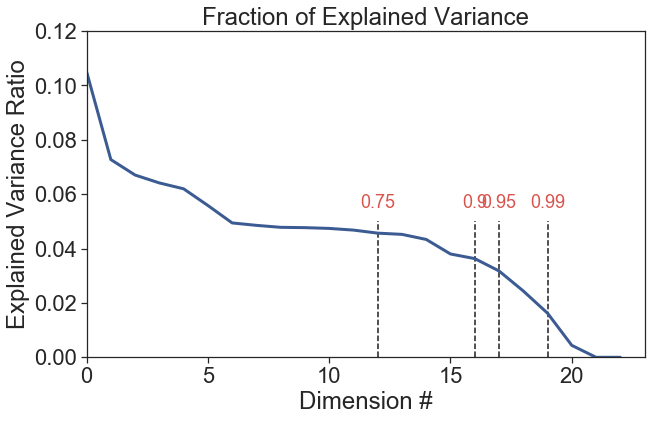

<Figure size 432x288 with 0 Axes>

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(X_train)

# We compute the cumulaive variance
lmts = [0.75, 0.9, 0.95, 0.99]
vars = np.cumsum(pca.explained_variance_ratio_)
vls = np.array([np.argmax(vars > i) for i in lmts])

# Make the plot
sns.set(style="ticks", font_scale=2.0)
fig, ax = plt.subplots(figsize=(10,6))

# Decorate the plot
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')

ax.set_xlim(0, 23.0)
ax.set_ylim(0, 0.12)

# Draw lines for the cumulative variance
ax.vlines(vls, 0.0, 0.05, linestyles='dashed') #colors=sns.xkcd_rgb)
for xl, txt in zip(vls, lmts):
    ax.text(xl, 0.055, str(txt), fontsize = 18, \
            color=sns.xkcd_rgb["pale red"], \
            horizontalalignment='center')
    
# Now draw the points, with bolder colors.
plt.plot(pca.explained_variance_ratio_, color=sns.xkcd_rgb["denim blue"], linewidth=3)

plt.show()
sns.despine(offset=5, trim=True)

We will pick n_components = 18 for PCA, which explains over 95% of variance.

In [26]:
# Apply PCA and standard scaler on the dataset
pca = PCA(n_components=18)
# Create scaler: scaler
scaler = StandardScaler()
# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

### 4c. Fit Linear Regression model

In [27]:
lm = LinearRegression(n_jobs=-1)
lmscore = ModelPerf(lm)

Train RMSE of LinearRegression model is: 0.024
Train RMSE of LinearRegression CV model is: 0.024
Test RMSE of LinearRegression model is: 0.022
Test R2 score of LinearRegression model is: 0.3012


### 4d. Fit Support Vector Regression model

In [28]:
C = 1.0  # SVR regularization parameter
lin_svr = SVR(kernel='linear', C=C)
lin_svrscore = ModelPerf(lin_svr)

Train RMSE of SVR model is: 0.033
Train RMSE of SVR CV model is: 0.034
Test RMSE of SVR model is: 0.032
Test R2 score of SVR model is: -0.5042


In [29]:
# # Feature engineering for kernel='rbf' with Grid Search
# param_grid = {'gamma':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}
# rbf_svr = SVR(kernel='rbf', C=C)
# grid_cv_rbf = GridSearchCV(rbf_svr, param_grid, cv=10, n_jobs=-1)
# grid_cv_rbf.fit(X_train, y_train)
# grid_cv_rbf.best_params_ 
# {'gamma': 0.0001}

rbf_svr = SVR(kernel='rbf', gamma=0.0001, C=C)
rbf_svrscore = ModelPerf(rbf_svr)

Train RMSE of SVR model is: 0.028
Train RMSE of SVR CV model is: 0.028
Test RMSE of SVR model is: 0.026
Test R2 score of SVR model is: -0.0457


In [30]:
# Feature engineering for kernel='poly' with Grid Search
# param_grid = {'degree':list(range(1,5))}
# poly_svr = SVR(kernel='poly', C=C)
# grid_cv_poly = GridSearchCV(poly_svr, param_grid, cv=10, n_jobs=-1)
# grid_cv_poly.fit(X_train, y_train)
# grid_cv_poly.best_params_
# {'degree': 1}

poly_svr = SVR(kernel='poly', degree=1, C=C)
poly_svrscore = ModelPerf(poly_svr)

Train RMSE of SVR model is: 0.033
Train RMSE of SVR CV model is: 0.034
Test RMSE of SVR model is: 0.032
Test R2 score of SVR model is: -0.5075


### 4e. Fit Decision Tree Regressor model

In [31]:
# Feature engineering for Decision Tree Regressor with Grid Search
# param_grid = {"max_depth": [2, 4, 6, 8],
#               "min_samples_leaf": list(range(1,11))}
# dt = DecisionTreeRegressor(random_state=SEED)
# grid_cv_dt = GridSearchCV(dt, param_grid, cv=10, n_jobs=-1)
# grid_cv_dt.fit(X_train, y_train)
# grid_cv_dt.best_params_
# {'max_depth': 8, 'min_samples_leaf': 9}

dt = DecisionTreeRegressor(max_depth= 8, min_samples_leaf= 9, random_state=SEED)
dtscore = ModelPerf(dt)

Train RMSE of DecisionTreeRegressor model is: 0.023
Train RMSE of DecisionTreeRegressor CV model is: 0.026
Test RMSE of DecisionTreeRegressor model is: 0.023
Test R2 score of DecisionTreeRegressor model is: 0.1884


### 4f. Fit Random Forest Regressor model

In [32]:
# Feature engineering for Random Tree Regressor with Grid Search
# param_grid = {"max_depth": [2, 4, 6, 8],
#               "min_samples_leaf": list(range(1,11)),
#              "n_estimators": [100, 200, 300, 400, 500]}
# rf = RandomForestRegressor(random_state=SEED)
# grid_cv_rf = GridSearchCV(rf, param_grid, cv=10, n_jobs=-1)
# grid_cv_rf.fit(X_train, y_train)
# grid_cv_rf.best_params_
# {'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 400}

rf = RandomForestRegressor(max_depth= 8, min_samples_leaf= 10, n_estimators = 400, random_state=SEED)
rfscore = ModelPerf(rf)

Train RMSE of RandomForestRegressor model is: 0.022
Train RMSE of RandomForestRegressor CV model is: 0.024
Test RMSE of RandomForestRegressor model is: 0.021
Test R2 score of RandomForestRegressor model is: 0.3126


### 4g. Fit Gradient Boosting Regressor model

In [33]:
# Feature engineering for Gradient Boosting Regressor with Grid Search
# param_grid = {"max_depth": [2, 4, 6, 8],
#               "loss": ['ls', 'lad', 'huber', 'quantile'],
#               "n_estimators": [100, 200, 300, 400, 500]}
# gb = GradientBoostingRegressor(random_state=SEED)
# grid_cv_gb = GridSearchCV(gb, param_grid, cv=10, n_jobs=-1)
# grid_cv_gb.fit(X_train, y_train)
# grid_cv_gb.best_params_
# {'loss': 'huber', 'max_depth': 4, 'n_estimators': 200}


gb = GradientBoostingRegressor(loss='huber', max_depth=4, n_estimators=200, random_state=SEED)
gbscore = ModelPerf(gb)

Train RMSE of GradientBoostingRegressor model is: 0.019
Train RMSE of GradientBoostingRegressor CV model is: 0.023
Test RMSE of GradientBoostingRegressor model is: 0.021
Test R2 score of GradientBoostingRegressor model is: 0.3524


### 4h. Fit Ada Boost Regressor model

In [34]:
ab = AdaBoostRegressor(base_estimator=gb, n_estimators=10, random_state=SEED)
abscore = ModelPerf(ab)

Train RMSE of AdaBoostRegressor model is: 0.015
Train RMSE of AdaBoostRegressor CV model is: 0.024
Test RMSE of AdaBoostRegressor model is: 0.021
Test R2 score of AdaBoostRegressor model is: 0.3396


### 4i. Fit Voting Regressor model

In [35]:
# Define regressors
regressors = [('Linear Regression', lm),('Random Forest',rf),('Ada Boost',ab),('Gradient Boosting',gb)]
vr = VotingRegressor(estimators=regressors, n_jobs=-1)
vrscore = ModelPerf(vr)

Train RMSE of VotingRegressor model is: 0.019
Train RMSE of VotingRegressor CV model is: 0.023
Test RMSE of VotingRegressor model is: 0.021
Test R2 score of VotingRegressor model is: 0.3605


### 4j. Fit Bagging Regressor model

In [36]:
# Take random forest model as the base because of its best performance
br = BaggingRegressor(base_estimator=gb, n_estimators=10,
n_jobs=-1, random_state=SEED)
brscore = ModelPerf(br)

Train RMSE of BaggingRegressor model is: 0.020
Train RMSE of BaggingRegressor CV model is: 0.023
Test RMSE of BaggingRegressor model is: 0.021
Test R2 score of BaggingRegressor model is: 0.3591


### 4k. The winner is...

In [37]:
perf_df = pd.DataFrame(data={"Train RMSE": [lmscore[0], lin_svrscore[0], rbf_svrscore[0], poly_svrscore[0],
                                       dtscore[0], rfscore[0], vrscore[0], brscore[0], gbscore[0], abscore[0]], 
                         "Train RMSE CV": [lmscore[1], lin_svrscore[1], rbf_svrscore[1], poly_svrscore[1],
                                       dtscore[1], rfscore[1], vrscore[1], brscore[1], gbscore[1], abscore[1]], 
                         "Test RMSE": [lmscore[2], lin_svrscore[2], rbf_svrscore[2], poly_svrscore[2],
                                       dtscore[2], rfscore[2], vrscore[2], brscore[2], gbscore[2], abscore[2]], 
                         "R2 Score": [lmscore[3], lin_svrscore[3], rbf_svrscore[3], poly_svrscore[3],
                                       dtscore[3], rfscore[3], vrscore[3], brscore[3], gbscore[3], abscore[3]]},
                  index=['Linear Regression', 'Linear SVR', 'RBF SVR', 'POLY SVR', 'Decision Tree',
                        'Random Forest', 'Voting Regression', 'Bagging Regression','Gradient Boosting',
                        'Ada Boost'])
perf_df = perf_df.sort_values(by=['R2 Score'], ascending=False)
perf_df[['Train RMSE','Train RMSE CV','Test RMSE']] = round(perf_df[['Train RMSE','Train RMSE CV','Test RMSE']],3)
perf_df[['R2 Score']] = perf_df['R2 Score'].map("{:.2%}".format)
perf_df

,Train RMSE,Train RMSE CV,Test RMSE,R2 Score
Voting Regression,0.019,0.023,0.021,36.05%
Bagging Regression,0.020,0.023,0.021,35.91%
Gradient Boosting,0.019,0.023,0.021,35.24%
Ada Boost,0.015,0.024,0.021,33.96%
Random Forest,0.022,0.024,0.021,31.26%
Linear Regression,0.024,0.024,0.022,30.12%
Decision Tree,0.023,0.026,0.023,18.84%
RBF SVR,0.028,0.028,0.026,-4.57%
Linear SVR,0.033,0.034,0.032,-50.42%
POLY SVR,0.033,0.034,0.032,-50.75%


Voting Regression model has the highest R2 score but the RMSE for training, for training CV and for test datasets are not very close. Bagging Regression's R2 score is just 0.14% lower than Voting Regression, but the three errors are much closwer. Therefore, we favor Bagging Regression over Voting Regression.

### 4l. Determine feature importance based on Gradient Boosting model

The fitted Gradient Boosting model above uses pca transformed data so feature columns do not imply anything. To evaluate which feature plays a more important role in terms of explaining the variance, we will bring back the orginal training and test data, refit Gradient Boosting model and plot the feature importance chart.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)

# Feature engineering for Gradient Boosting Regressor with Grid Search
# param_grid = {"max_depth": [2, 4, 6, 8],
#               "loss": ['ls', 'lad', 'huber', 'quantile'],
#               "n_estimators": [100, 200, 300, 400, 500]}
# gb = GradientBoostingRegressor(random_state=SEED)
# grid_cv_gb = GridSearchCV(gb, param_grid, cv=10, n_jobs=-1)
# grid_cv_gb.fit(X_train, y_train)
# grid_cv_gb.best_params_
# {'loss': 'huber', 'max_depth': 6, 'n_estimators': 200}

gb1 = GradientBoostingRegressor(loss='huber', max_depth=6, n_estimators=200, random_state=SEED)
gb1score = ModelPerf(gb1)

Train RMSE of GradientBoostingRegressor model is: 0.016
Train RMSE of GradientBoostingRegressor CV model is: 0.023
Test RMSE of GradientBoostingRegressor model is: 0.020
Test R2 score of GradientBoostingRegressor model is: 0.3997


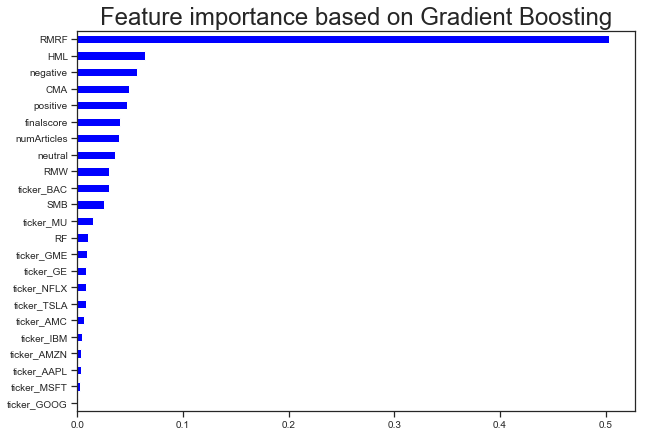

All Fama-French factors explain 67.1% of feature importance.
All Sentiment scores explain 17.9% of feature importance.


In [39]:
# Create a pd.Series of features importances, based on gb
import matplotlib.pyplot as plt
importances_gb = pd.Series(gb1.feature_importances_,
index = X_train.columns)
plt.rc('figure', figsize=(10, 7))
fig, ax = plt.subplots()
# Sort importances_gb
sorted_importances_gb = importances_gb.sort_values()
# Make a horizontal bar plot
sorted_importances_gb.plot(kind='barh', color='blue')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Feature importance based on Gradient Boosting")
plt.show()

# # Create a pd.Series of features importances, based on rf
# import matplotlib.pyplot as plt
# importances_rf = pd.Series(rf1.feature_importances_,
# index = X_train.columns)
# plt.rc('figure', figsize=(10, 7))
# fig, ax = plt.subplots()
# # Sort importances_rf
# sorted_importances_rf = importances_rf.sort_values()
# # Make a horizontal bar plot
# sorted_importances_rf.plot(kind='barh', color='blue')
# ax.tick_params(axis='both', which='major', labelsize=10)
# plt.show()

# sorted_importances_rf1 = importances_rf.sort_values(ascending=False)
# print('All Fama-French factors explain ' + "{:.1%}".format(sum(sorted_importances_rf1[['RMRF','HML','CMA','RMW','SMB']]),2) + ' of feature importance.') 
# print('All Sentiment scores explain ' + "{:.1%}".format(sum(sorted_importances_rf1[['negative','positive','neutral','finalscore']]),2) + ' of feature importance.') 

sorted_importances_gb1 = importances_gb.sort_values(ascending=False)
print('All Fama-French factors explain ' + "{:.1%}".format(sum(sorted_importances_gb1[['RMRF','HML','CMA','RMW','SMB']]),2) + ' of feature importance.') 
print('All Sentiment scores explain ' + "{:.1%}".format(sum(sorted_importances_gb1[['negative','positive','neutral','finalscore']]),2) + ' of feature importance.') 

The bar plot aboves shows feature importance based on how well the excess return is explained by that feature from Gradient Boosting model. The 'RMRF' takes a strong position which explains 50% of importance. 'HML' takes the second place which explains roughly 8%. Also, note all Fama French factors contribute over 67% to the overall importance. We also notice that the sentiment scores (final score, negative, positive, neutral) combined, explain 18% of feature importance.

## 5. Clustering

In stock markets, there is the term 'Buy the Rumor, Sell the News'. If our Sentiment Score is high, then possibly, the news is already reflected in the stock price. So our next question is: are we buying at a high price and selling at a low price? Here, we used the clustering method to identify any abnormal return found on the return distribution to test this. 

In [40]:
# Create df for cluster model; This is based on FinBERT model
df1_cluster = df1.drop(['numArticles', 'neutral', 'positive','negative',
              'movingavg20d','ticker'], axis=1, inplace=False)
df1_cluster = df1_cluster.set_index('date')
# Normalize the data
stscaler = StandardScaler().fit(df1_cluster)
df1_cluster = stscaler.transform(df1_cluster)

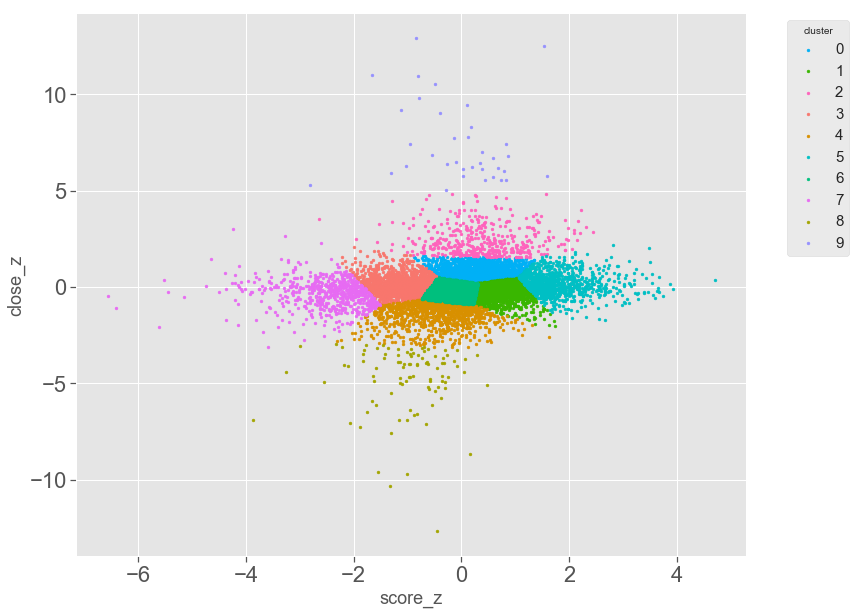

In [41]:
from sklearn.cluster import KMeans

# Fit Kmeans
k_means = KMeans(n_clusters=10, random_state=SEED)
k_means.fit(df1_cluster)
# Obtain the labels
labels = k_means.predict(df1_cluster)

# Get unique labels
uniq_labels = np.unique(labels)
plt.rcParams['figure.figsize'] = (12, 10)
plt.style.use('ggplot')
clr = ["#00B0F6","#39B600","#FF62BC","#F8766D","#D89000","#00BFC4","#00BF7D","#E76BF3","#A3A500","#9590FF"]
# Plot the results:
for i in uniq_labels:
    plt.scatter(df1_cluster[labels == i , 1] , df1_cluster[labels == i , 0] , color = clr[i], label = i, s = 8)
plt.xlabel('score_z', fontsize=18)
plt.ylabel('close_z', fontsize=18) 
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), fontsize=18, loc='upper left', prop={'size': 15})
plt.show()

On the Northeast side, we found more clustering with the positive returns and positive sentiments. On the Southwest side, we found more clustering with the negative returns and negative sentiments. The abnormal returns found on the center not on the tail. Therefore, we are not buying a high price and selling at a low price.

## 6. Summary

Overall, there is still a room to improve in terms of the prediction power on excess return for the fitted model, as the R2 score is just over 36%. We can include more meaningful features or spend more time on feature engineering to improve the score. Upon completion of the project, we learn four things.

First, FinBERT model outperforms LSTM model in terms of producing better and more accurate sentiment score.

Second, the inclusion of sentiment as the six factor scores improves the traditional Fach-French model.

Third, when fitting regression model to predict excess returns, the Fama-French factors explain over 67% of feature importance and the sentiment scores explain over 18% of feature importance.

Fourth, from an investor perspective, we are not buying a high price and selling at a low price.